In [1]:
# 주택 가격 예측: 회귀 문제
# 개별적인 레이블 대신에 연속적인 값을 예측하는 회귀(regression). 
# 회귀와 로지스틱 회귀(logistic regression) 알고리즘을 혼동. 로지스틱 회귀는 회귀 알고리즘이 아니라 분류 알고리즘이다.

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 7us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### 데이터 준비

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 된다. 이런 데이터를 다룰때 대표적인 방법은 특성별로 정규화를 하는 것. 입력 데이터에 이쓴ㄴ 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눈다. (정규화는 여러 가지 다른 의미로도 사용되기 떄문에 오해하기 쉽다. 표준화(standardization)라고 하면 정확히 이 방식을 가리킨다.) 특성의 중앙이 0 근처에 맞추어 지고 표준 편차가 1이된다.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

**테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한 값임을 주목. 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안된다.**

In [10]:
# 모델 구성
# 샘플 개수가 적기 떄문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크를 구성하여 사용. 
# 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다

from keras import models
from keras import layers

# 이 네트워크의 마지막 층은 활성화 함수가 없다. (선형 층이라고 부른다) 이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성.
# 활성화 함수를 적용하면 출력 값의 범위가 제한된다. 여기서는 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습
# mse 손실함수를 사용. 평균 제곱 오차(mean squared error)의 약어. 회귀문제에 널리 사용되는 손실함수
# 모니터링을 위해 평균 절대 오차(Mean Absolute Error, MAE)를 측정.
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 교차 검증 (K-fold cross-validation)

데이터를 K개의 분할(즉 폴드(fold))로 나누고(일반적으로 K=4 또는 5), K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법. 모델의 검증 점수는 K개의 검증 점수 평균이 된다.

In [19]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [20]:
all_scores

[2.274263851713426, 2.988141900241965, 2.772962851099449, 2.8689947045675597]

In [21]:
np.mean(all_scores)

2.7260908269056

In [22]:
# 각 폴드에서 검증 점수를 로그에 저장
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [31]:
# K-겹 검증 점수 평균을 기록
average_mae_history  = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

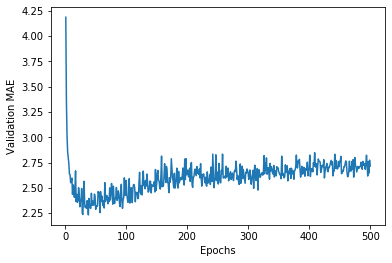

In [33]:
# 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 위 그래프는 범위가 크고 변동이 심하기 때문에 보기 어렵다.

- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 **지수 이동 평균**(exponential moving average)으로 대체한다.

지수 이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나. 

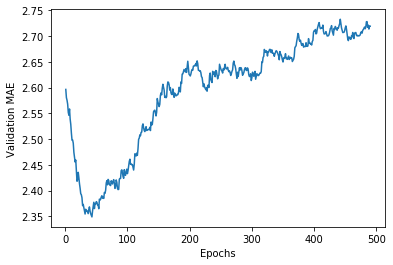

In [40]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            # smoothed_points된 이동 평균에 factor를 곱하고 현재 포인트에 (1 - factor)를 곱해 합산
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

**위 그래프를 보면 검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈추었다. 이 지점 이후로는 과대적합이 시작**

In [41]:
# 최종 모델 훈련
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [42]:
test_mae_score # 아직 2,675 달러 정도 차이가 난다.

2.872347027647729

20.1614990234375